In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [22]:
from collections import defaultdict
from datasets import DatasetDict, concatenate_datasets
from seqeval.metrics import f1_score
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments
from transformers import XLMRobertaForTokenClassification
from typing import Dict, Any

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('../../data/panx_ch.pkl', 'rb') as fh:
    panx_ch = pickle.load(fh)

In [6]:
tags = panx_ch['de']['train'].features['ner_tags'].feature
num_labels = tags.num_classes
label2id = {tag:idx for idx, tag in enumerate(tags.names)}
id2label = {idx:tag for idx, tag in enumerate(tags.names)}

In [7]:
model_checkpoint = 'xlm-roberta-base'
xlmr_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
xlmr_config = AutoConfig.from_pretrained(model_checkpoint,
                                         label2id=label2id,
                                         id2label=id2label)

In [8]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples['tokens'],
                                     truncation=True,
                                     is_split_into_words=True)
    labels=[]
    for idx, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs['labels'] = labels
    return tokenized_inputs


def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels,
                      batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])
    

panx_de_encoded = encode_panx_dataset(panx_ch['de'])
panx_de_encoded

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 12580
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 6290
    })
})

In [9]:
def align_predictions(label_ids, predictions):
    preds = np.argmax(predictions, axis=-1)
    y_true, y_pred = [], []
    for sample_true_labels, sample_predicted_labels in zip(label_ids, preds):
        sample_y_true, sample_y_preds = [], []
        for token_true_label, token_predicted_label in zip(sample_true_labels, sample_predicted_labels):
            if token_true_label == -100:
                continue

            sample_y_true.append(id2label[token_true_label])
            sample_y_preds.append(id2label[token_predicted_label])
        y_true.append(sample_y_true)
        y_pred.append(sample_y_preds)
    return y_true, y_pred


def compute_merics(eval_prediction):
    y_true, y_pred = align_predictions(eval_prediction.label_ids,
                                       eval_prediction.predictions)
    return {'f1':f1_score(y_true, y_pred)}


def load_trainer_state(trainer: Trainer, load_dir: str) -> Dict[str, Any]:
    """
    Load a previously saved Trainer state.

    Args:
        trainer: The Trainer object to load the state into
        load_dir: Directory containing the saved state

    Returns:
        Dictionary containing any additional info that was saved
    """
    # Load training arguments if they exist
    # training_args_path = os.path.join(load_dir, "training_args.json")
    # if os.path.exists(training_args_path):
    #     with open(training_args_path, "r") as f:
    #         training_args_dict = json.load(f)
    #         # Create new TrainingArguments object with loaded values
    #         trainer.args = TrainingArguments(**training_args_dict)

    # Load the model
    trainer.model.load_state_dict(
        torch.load(os.path.join(load_dir, "pytorch_model.bin"))
    )

    # Load optimizer state if it exists
    optimizer_path = os.path.join(load_dir, "optimizer.pt")
    if os.path.exists(optimizer_path) and trainer.optimizer is not None:
        trainer.optimizer.load_state_dict(
            torch.load(optimizer_path)
        )

    # Load scheduler state if it exists
    scheduler_path = os.path.join(load_dir, "scheduler.pt")
    if os.path.exists(scheduler_path) and trainer.lr_scheduler is not None:
        trainer.lr_scheduler.load_state_dict(
            torch.load(scheduler_path)
        )

    # Load training state
    with open(os.path.join(load_dir, "trainer_state.json"), "r") as f:
        state_dict = json.load(f)

    # Update trainer state
    trainer.state.epoch = state_dict["epoch"]
    trainer.state.global_step = state_dict["global_step"]
    trainer.state.max_steps = state_dict["max_steps"]
    trainer.state.num_train_epochs = state_dict["num_train_epochs"]
    trainer.state.log_history = state_dict["log_history"]
    trainer.state.best_metric = state_dict["best_metric"]
    trainer.state.best_model_checkpoint = state_dict["best_model_checkpoint"]

    # Return any additional info that was saved
    return state_dict.get("additional_info", {})


def model_init():
    return XLMRobertaForTokenClassification.from_pretrained(model_checkpoint,
                                                            config=xlmr_config).to(device)
    
    
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics['test_f1']


def tag_text(tokenizer, model, tags, text):
    tokenized_input = tokenizer(text, truncation=True, return_tensors='pt')
    tokens = tokenized_input.tokens()
    input_ids = tokenized_input['input_ids'].to(device)
    output = model(input_ids)
    predictions = torch.argmax(output.logits, dim=-1)[0].cpu().numpy()
    predicted_ner_tags = tags.int2str(predictions)
    return pd.DataFrame({'Tokens':tokens, 'Tags':predicted_ner_tags}).T


def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds['test'])

In [10]:
# model training arguments
num_epochs=3
batch_size=32
logging_steps = len(panx_de_encoded['train']) // batch_size
model_name = f'{model_checkpoint}_finetuned_panx_de'
training_args = TrainingArguments(output_dir=model_name,
                                  log_level='error',
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  learning_rate=5e-5,
                                  weight_decay=0.01,
                                  num_train_epochs=num_epochs,
                                  logging_steps=logging_steps,
                                  save_steps=1e6, # avoiding saving checkpoints
                                  seed=42,
                                  fp16=False,
                                  disable_tqdm=False,
                                  push_to_hub=False)

In [11]:
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)
trainer = Trainer(model_init=model_init,
                  args = training_args,
                  data_collator=data_collator,
                  train_dataset=panx_de_encoded['train'],
                  eval_dataset=panx_de_encoded['validation'],
                  compute_metrics=compute_merics,
                  tokenizer=xlmr_tokenizer)

load_trainer_state(trainer, load_dir="../../data/panx_de_checkpoints")

{}

In [12]:
f1_scores = defaultdict(dict)
f1_scores['de']['de'] = get_f1_score(trainer, panx_de_encoded['test'])
print(f'F1-score of [de] model on [de] dataset: {f1_scores["de"]["de"]:.3f}')

F1-score of [de] model on [de] dataset: 0.858


In [13]:
text_fr = 'Jeff Dean est informaticien chez Google en Californie'
df = tag_text(xlmr_tokenizer, trainer.model, tags, text_fr)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [14]:
f1_scores['de']['fr'] = evaluate_lang_performance('fr', trainer)
print(f'F1-score of [de] model on [fr] dataset: {f1_scores["de"]["fr"]:.3f}')
f1_scores['de']['it'] = evaluate_lang_performance('it', trainer)
print(f'F1-score of [de] model on [it] dataset: {f1_scores["de"]["it"]:.3f}')
f1_scores['de']['en'] = evaluate_lang_performance('en', trainer)
print(f'F1-score of [de] model on [en] dataset: {f1_scores["de"]["en"]:.3f}')

F1-score of [de] model on [fr] dataset: 0.695


F1-score of [de] model on [it] dataset: 0.668


F1-score of [de] model on [en] dataset: 0.585


In [15]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset['train'].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset['validation']
    test_ds = dataset['test']
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init,
                      args=training_args,
                      data_collator=data_collator,
                      train_dataset=train_ds,
                      eval_dataset=valid_ds,
                      compute_metrics=compute_merics,
                      tokenizer=xlmr_tokenizer)
    trainer.train()

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict({'num_samples': [len(train_ds)],
                                   'f1_score': [f1_score]})

In [17]:
panx_fr_encoded = encode_panx_dataset(panx_ch['fr'])
metrics_df = train_on_subset(panx_fr_encoded, 250)

for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = pd.concat([metrics_df, train_on_subset(panx_fr_encoded, num_samples)], axis=0)
metrics_df.reset_index(inplace=True, drop=True)
metrics_df

Epoch,Training Loss,Validation Loss,F1
1,1.598300,1.341212,0.000000
2,1.270000,1.150891,0.100866
3,1.058200,1.072993,0.173347


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.390500,1.025529,0.239655
2,0.868500,0.718515,0.507634
3,0.675800,0.599578,0.598168


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.179900,0.692190,0.538553
2,0.555700,0.412383,0.709317
3,0.353600,0.380814,0.751840


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.805100,0.395838,0.740753
2,0.332400,0.363540,0.763354
3,0.233000,0.335833,0.805000


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.639200,0.332109,0.785488
2,0.284900,0.278502,0.824777
3,0.191600,0.274823,0.832352


,num_samples,f1_score
0,250,0.166210
1,500,0.610412
2,1000,0.750078
3,2000,0.809335
4,4000,0.838503


<Axes: xlabel='num_samples'>

Text(0.5, 0, 'number of training examples')

Text(0, 0.5, 'f1-score')

(0.0, 1.0)

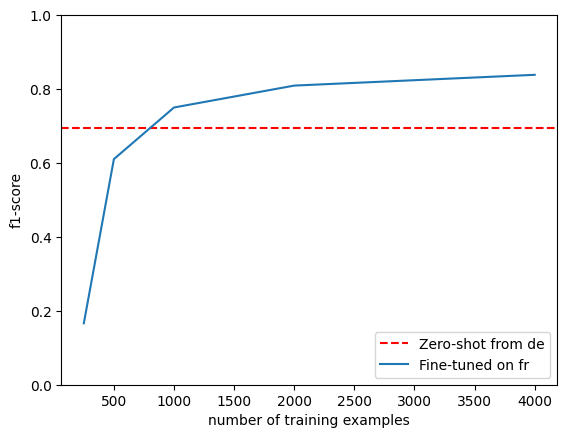

In [18]:
fig, ax = plt.subplots()
ax.axhline(f1_scores['de']['fr'], color='r', ls='--')
metrics_df.set_index('num_samples').plot(ax=ax)
plt.xlabel('number of training examples')
plt.ylabel('f1-score')
plt.ylim((0, 1))
plt.legend(['Zero-shot from de', 'Fine-tuned on fr'], loc='lower right')
plt.show()

In [19]:
# combining the training data from de and fr and checking the F1 on all 4 datasets
def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [23]:
training_args.output_dir = 'xlm-roberta-base-finetuned-de-fr'
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])
training_args.logging_steps = len(panx_de_fr_encoded['train'])//batch_size
trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=panx_de_fr_encoded['train'],
                  eval_dataset=panx_de_fr_encoded['validation'],
                  compute_metrics=compute_merics,
                  tokenizer=xlmr_tokenizer)
trainer.train()

/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.284100,0.178617,0.825731
2,0.148900,0.158236,0.852414
3,0.097100,0.160195,0.858621


TrainOutput(global_step=1611, training_loss=0.1764963816442081, metrics={'train_runtime': 107.2522, 'train_samples_per_second': 479.99, 'train_steps_per_second': 15.021, 'total_flos': 1217861247419520.0, 'train_loss': 0.1764963816442081, 'epoch': 3.0})

In [24]:
langs = ['de', 'fr', 'it', 'en']
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f'F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}')

F1-score of [de-fr] model on [de] dataset: 0.866


F1-score of [de-fr] model on [fr] dataset: 0.856


F1-score of [de-fr] model on [it] dataset: 0.794


F1-score of [de-fr] model on [en] dataset: 0.669


In [26]:
corpora = [panx_de_encoded]
for lang in langs[1:]:
    training_args.output_dir = f'xlm-roberta-base-finetuned-panx-{lang}'
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded['train'].num_rows)
    f1_scores[lang][lang] = metrics['f1_score'][0]
    corpora.append(ds_encoded)

/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.568100,0.306228,0.781173
2,0.273500,0.266561,0.827876
3,0.185600,0.263512,0.843240


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.796400,0.392766,0.729158
2,0.330800,0.300538,0.784539
3,0.227400,0.257092,0.806347


/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,1.093500,0.574366,0.547831
2,0.545800,0.435822,0.654808
3,0.388400,0.405410,0.677492


In [27]:
corpora_encoded = concatenate_splits(corpora)
training_args.output_dir = 'xlm-roberta-base-finetuned-panx_all'
training_args.logging_steps = len(corpora_encoded['train'])//batch_size

trainer = Trainer(model_init=model_init,
                  args=training_args,
                  data_collator=data_collator,
                  train_dataset=corpora_encoded['train'],
                  eval_dataset=corpora_encoded['validation'],
                  compute_metrics=compute_merics,
                  tokenizer=xlmr_tokenizer)
trainer.train()

/home/karvsmech/miniconda3/envs/ptorch/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.295200,0.186461,0.823624
2,0.154900,0.166941,0.846974
3,0.105000,0.169090,0.855110


TrainOutput(global_step=1878, training_loss=0.1848798668422638, metrics={'train_runtime': 126.5603, 'train_samples_per_second': 474.556, 'train_steps_per_second': 14.839, 'total_flos': 1393252375237008.0, 'train_loss': 0.1848798668422638, 'epoch': 3.0})

In [28]:
for idx, lang in enumerate(langs):
    f1_scores['all'][lang] = get_f1_score(trainer, corpora[idx]['test'])
f1_scores

defaultdict(dict,
            {'de': {'de': 0.8575612503520136,
              'fr': 0.6951493735946033,
              'it': 0.6683782627299958,
              'en': 0.5851183765501691},
             'fr': {'fr': 0.8381410256410255},
             'it': {'it': 0.8090753424657534},
             'en': {'en': 0.695344725987036},
             'all': {'de': 0.8636978579481397,
              'fr': 0.864882400648824,
              'it': 0.860759493670886,
              'en': 0.7832335329341318}})

In [29]:
scores_data = {'de': f1_scores['de'],
              'each': {lang: f1_scores[lang][lang] for lang in langs},
              'all': f1_scores['all']}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index='Fine-tune-on', columns='Evaluated on', inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune-on,,,,
de,0.8576,0.6951,0.6684,0.5851
each,0.8576,0.8381,0.8091,0.6953
all,0.8637,0.8649,0.8608,0.7832
